In [1]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap
from models import HD_cell_L1, PC_cell_L2

#for plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

from scipy.interpolate import interp1d
import pycircstat.descriptive as cd

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

In [2]:
def simulate_honeycomb_movement(
    total_time=1, 
    dt=0.01, 
    move_prob=0.95, 
    drift_factor=0.0, 
    velocity=0.5, 
    rotation_speed=np.pi / 50,
    stick_length=0.2,
    goal_loc=[0, 0]
):
    
    env_size = 1.0
    time_steps = int(total_time / dt)

    pos_A = np.array([env_size / 2, env_size / 2])
    angle = 0
    pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])
    move_angle = np.random.uniform(-np.pi, np.pi)

    B_trajectory = []
    head_directions = []
    rotation_phases = []
    rotation_direction_log = []
    time_list = []
    breakTimepoints = []  # Initialise list


    step_count = 0
    current_time = 0
    just_rotated = False  # New flag to prevent back-to-back rotations

    while step_count < time_steps:
        if (np.random.rand() < move_prob and not just_rotated) or just_rotated:
            
            move_angle = (drift_factor * move_angle) + ((1 - drift_factor) * np.random.uniform(-np.pi, np.pi))
            step_size = velocity * dt
            new_pos_A = pos_A + step_size * np.array([np.cos(move_angle), np.sin(move_angle)])
            new_pos_A = np.clip(new_pos_A, 0, env_size)
            pos_A = new_pos_A
            pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

            B_trajectory.append(pos_B.copy())
            head_directions.append(angle)
            rotation_phases.append(False)
            rotation_direction_log.append(0)
            time_list.append(current_time)

            step_count += 1
            current_time += dt
            just_rotated = False  # Reset flag after movement
        else:
            # Randomly choose rotation direction: +1 (CW) or -1 (CCW)
            direction_flag = np.random.choice([1, -1])
            rotation_duration = int(np.random.uniform(0.6, 1.0) / dt)

            for _ in range(min(rotation_duration, time_steps - step_count)):
                angle -= direction_flag * rotation_speed  # CW = -rotation
                angle = (angle + np.pi) % (2 * np.pi) - np.pi
                pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

                # Check alignment with goal direction
                vec_to_goal = goal_loc - pos_A
                dir_to_goal = np.arctan2(vec_to_goal[1], vec_to_goal[0])
                angle_diff = ((angle - dir_to_goal + np.pi) % (2 * np.pi)) - np.pi  # Wrap to [-π, π]

                if np.abs(angle_diff) < np.deg2rad(10):  # e.g. 5° threshold
                    breakTimepoints.append(current_time)  # Record the time when aligned
                    break  # Stop rotation if aligned


                B_trajectory.append(pos_B.copy())
                head_directions.append(angle)
                rotation_phases.append(True)
                rotation_direction_log.append(direction_flag)
                time_list.append(current_time)

                step_count += 1
                current_time += dt
                if step_count >= time_steps:
                    break
                
            just_rotated = True  # Mark that a rotation just occurred

    B_trajectory = np.array(B_trajectory)
    head_directions = np.array(head_directions)
    rotation_phases = np.array(rotation_phases)
    rotation_direction_log = np.array(rotation_direction_log)
    time_original = np.array(time_list)

    displacement = np.linalg.norm(np.diff(B_trajectory, axis=0), axis=1)
    speeds = np.concatenate(([0], displacement / dt))

    dt_new = 0.001
    time_upsampled = np.arange(0, time_original[-1] + dt_new, dt_new)

    interp_B_x = interp1d(time_original, B_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_B_y = interp1d(time_original, B_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_head_dir = interp1d(time_original, head_directions, kind='linear', fill_value="extrapolate")
    interp_speeds = interp1d(time_original, speeds, kind='linear', fill_value="extrapolate")

    B_trajectory_upsampled = np.vstack((interp_B_x(time_upsampled), interp_B_y(time_upsampled))).T
    head_directions_upsampled = interp_head_dir(time_upsampled)
    speeds_upsampled = interp_speeds(time_upsampled)
    head_directions_upsampled = (head_directions_upsampled + np.pi) % (2 * np.pi) - np.pi

    interp_rotation_phase = interp1d(time_original, rotation_phases, kind='nearest', fill_value="extrapolate")
    rotation_phases_upsampled = interp_rotation_phase(time_upsampled).astype(bool)

    interp_rotation_dir = interp1d(time_original, rotation_direction_log, kind='nearest', fill_value="extrapolate")
    rotation_direction_upsampled = interp_rotation_dir(time_upsampled).astype(int)

    vec_to_goal = goal_loc - B_trajectory_upsampled
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])

    diff = np.diff(B_trajectory_upsampled, axis=0)
    Velocity = np.zeros_like(B_trajectory_upsampled)
    Velocity[:-1, :] = diff
    MVDirection = (np.arctan2(Velocity[:, 1], Velocity[:, 0]) + np.pi) % (2 * np.pi) - np.pi
    
    break_indices = np.searchsorted(time_upsampled, breakTimepoints)

    return (
        B_trajectory_upsampled,
        head_directions_upsampled,
        MVDirection,
        Dir2Goal,
        speeds_upsampled,
        rotation_phases_upsampled,
        time_upsampled,
        Velocity,
        rotation_direction_upsampled,
        break_indices
    )


## Section 1: Generate simple trajectory to test model parameters

2025-06-26 22:31:17.788343: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%


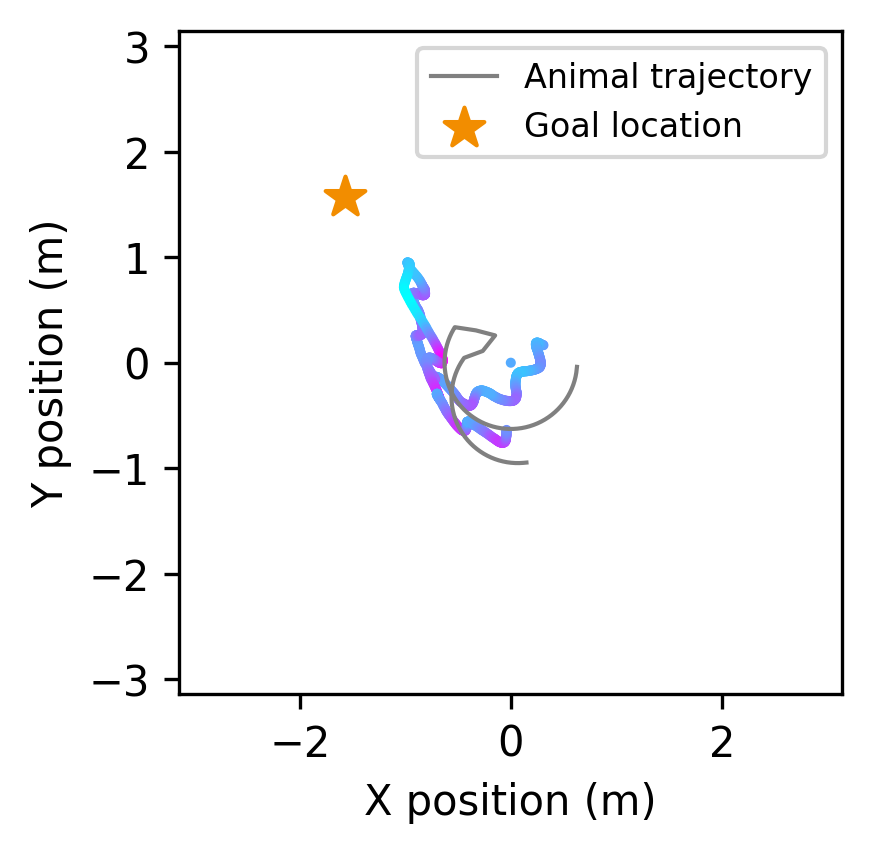

In [3]:
np.random.seed(42)  # For reproducibility

#--------------------------simulate trajectory---------------------------
goal_loc = [-0.5*np.pi, 0.5*np.pi]  
goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

direction = 'clockwise' 
# Run the function to generate movement data
results = simulate_honeycomb_movement(total_time=1, 
                                    dt=0.01, 
                                    move_prob=0.70, 
                                    drift_factor=0.0, 
                                    velocity=6,
                                    rotation_speed=np.pi / 50,
                                    stick_length = 0.2,
                                    goal_loc=goal_loc_in_traj)

Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all, Rotation_direction_all, break_indices = results

Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all = Animal_speed_all/1000

#--------------------------simulate movement---------------------------

#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 5. #HD adaptation strength 
mbar_pc = 5. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.5
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.5 # default 0.5; maximal 0.5,
Topdown_mod = 5.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=True)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 1.0,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    results = run(time_steps[i:i+simulate_time], 
                    Animal_location_all[i:i+simulate_time], 
                    MV_direction_all[i:i+simulate_time],
                    Animal_speed_all[i:i+simulate_time],
                    Dir2Goal_all[i:i+simulate_time])
    
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = results
    
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)
    
#--------------------------plot---------------------------

fig, ax  = plt.subplots(1, 1, figsize=(3,3), dpi=300)
num = 50
z_max = np.pi
time_steps = np.arange(len(Animal_location_all))
max_r_grid = np.max(pc_activity, axis=(1,2)) 

# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color='grey', linewidth=1, label='Animal trajectory')
ax.scatter(goal_loc[0], goal_loc[1], color='#F28D00', marker='*', s=100, label='Goal location')

sc = ax.scatter(
                pc_bumpcenter[:, 0],
                pc_bumpcenter[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=2,
        )

ax.set_aspect('equal')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.legend(fontsize=8)
ax.set_xlabel('X position (m)', fontsize=10)
ax.set_ylabel('Y position (m)', fontsize=10)

plt.tight_layout()

## Section 2: simulate a long spinning trajectory

/tmp/ipykernel_608881/2518505596.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


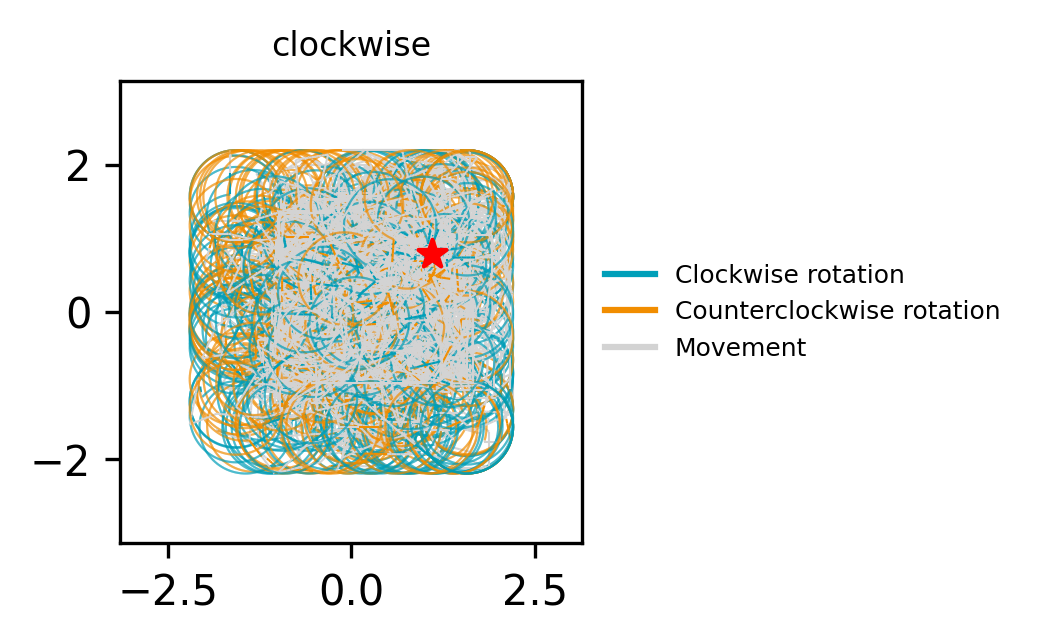

In [4]:
# Seed for reproducibility
# np.random.seed(111)
goal_loc = [0.35*np.pi, 0.25*np.pi]

goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

results = simulate_honeycomb_movement(total_time=400, 
                                    dt=0.01, 
                                    move_prob=0.80, 
                                    drift_factor=0.0, 
                                    velocity=20,
                                    rotation_speed=np.pi / 50,
                                    stick_length = 0.2,
                                    goal_loc=goal_loc_in_traj)

Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all, Rotation_direction_all, break_indices = results

Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all /= 1000

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)

# Create line segments and assign colours
segments = np.array([
    [Animal_location_all[i], Animal_location_all[i + 1]] 
    for i in range(len(Animal_location_all) - 1)
])

colors = []
for i in range(len(Animal_location_all) - 1):
    if rotation_phases[i]:
        if Rotation_direction_all[i] == 1:
            colors.append('#009FB9')   # Clockwise: blue
        elif Rotation_direction_all[i] == -1:
            colors.append('#F18D00')   # Counterclockwise: orange
        else:
            colors.append('lightgrey')  # Should not occur
    else:
        colors.append('lightgrey')      # Movement phase

# Add to plot
lc = LineCollection(segments, colors=colors, linewidths=0.5, alpha=1)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)

# Plot goal location
ax.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=50, zorder=10)

ax.set_title(direction, fontsize=8)

# Define custom legend handles
legend_elements = [
    Line2D([0], [0], color='#009FB9', lw=1.5, label='Clockwise rotation'),
    Line2D([0], [0], color='#F18D00', lw=1.5, label='Counterclockwise rotation'),
    Line2D([0], [0], color='lightgrey', lw=1.5, label='Movement')
]

# Add legend outside the plot box (right side)
ax.legend(handles=legend_elements, 
          loc='center left', 
          bbox_to_anchor=(1.0, 0.5), 
          frameon=False, 
          fontsize=6)

plt.tight_layout()

In [5]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 5. #HD adaptation strength 
mbar_pc = 5. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.5
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.5 # default 0.5; maximal 0.5,
Topdown_mod = 5.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=True)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.5,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], 
                                                                                                        Animal_location_all[i:i+simulate_time], 
                                                                                                        MV_direction_all[i:i+simulate_time],
                                                                                                        Animal_speed_all[i:i+simulate_time],
                                                                                                        Dir2Goal_all[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

Running simulation...
Simulation progress: 0%


Simulation progress: 13%
Simulation progress: 25%
Simulation progress: 38%
Simulation progress: 50%
Simulation progress: 63%
Simulation progress: 75%
Simulation progress: 88%


In [6]:
# Compute relative angles in range [-π, π]
relative_angle = np.zeros(len(Head_direction_all))

for i in range(len(Head_direction_all)):
    # Unit vector of head direction
    vec1 = np.array([np.cos(Head_direction_all[i]), np.sin(Head_direction_all[i])])
    
    # Vector from current position to goal
    vec2 = goal_loc - Animal_location_all[i]  # (goal - current position)
    vec2 = vec2 / np.linalg.norm(vec2)  # Normalize vec2
    
    # Compute the signed angle using atan2
    relative_angle[i] = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec1[1], vec1[0])
    
    # Wrap angle to range [-π, π]
    relative_angle[i] = (relative_angle[i] + np.pi) % (2 * np.pi) - np.pi

In [7]:
goal_loc

[1.0995574287564276, 0.7853981633974483]

(-0.5, 24.5, -0.5, 24.5)

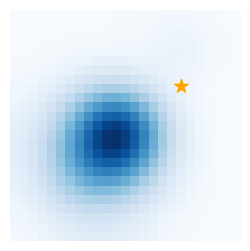

In [8]:
fig, ax = plt.subplots(1,1, figsize=(3,3))

cellindex = [24, 24]
num = 50

Position_norm = (Animal_location_all - Animal_location_all.min()-1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)

ax.imshow(tuningMap, origin='lower', cmap='Blues')

#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.set_aspect('equal')

ax.axis('off')

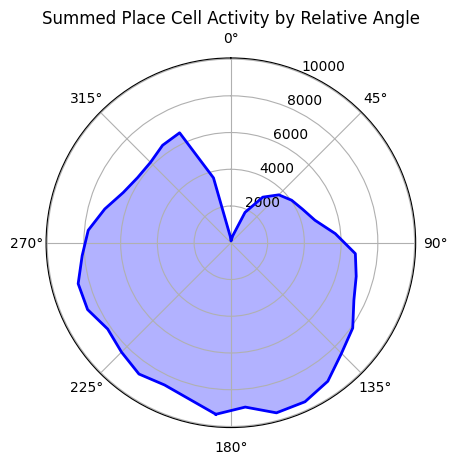

In [9]:
cellindex = [24, 24]


pc_activity_i=pc_activity[:, cellindex[0], cellindex[1]]

#cloclwise
pc_activity_i = pc_activity_i[Rotation_direction_all==1]
relative_angle_cw = relative_angle[Rotation_direction_all==1]

# Define bins for relative angles from -π to π
num_bins = 36
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers

# Initialize summed activity for each bin
binned_activity = np.zeros(num_bins)

# Assign each relative angle to a bin and sum corresponding activity
bin_indices = np.digitize(relative_angle_cw, angle_bins) - 1  # -1 to convert to 0-based index

for i in range(len(relative_angle_cw)):
    if 0 <= bin_indices[i] < num_bins:  # Ensure within valid bin range
        binned_activity[bin_indices[i]] += pc_activity_i[i]

# Convert bin centers to a polar coordinate system
theta = bin_centers

# Close the circle by repeating first value at the end
theta = np.append(theta, theta[0])

binned_activity = np.append(binned_activity, binned_activity[0])

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, binned_activity, color='blue', linewidth=2)
ax.fill(theta, binned_activity, color='blue', alpha=0.3)  # Fill for better visibility

ax.set_title("Summed Place Cell Activity by Relative Angle")

#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 

plt.show()

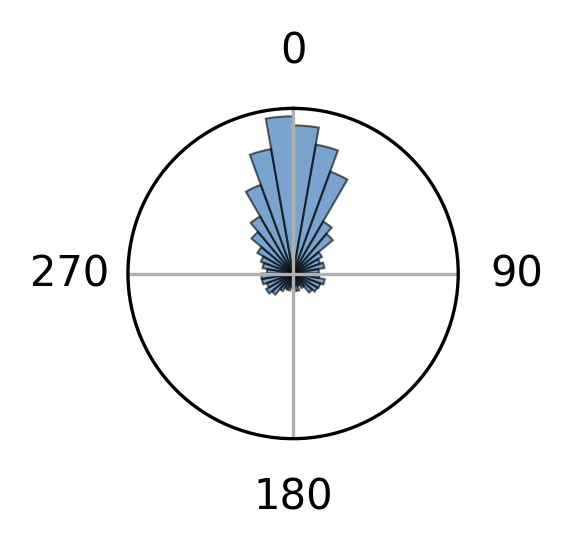

In [19]:
# Define the range of cell indices
start_idx = 15
end_idx = 35  # inclusive

# Define bins for relative angles from -π to π
num_bins = 36
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

# Initialize accumulator for summed activity across all selected cells
total_binned_activity = np.zeros(num_bins)
num_cells = 0

# Loop through the specified submatrix of cells
for i in range(start_idx, end_idx + 1):
    for j in range(start_idx, end_idx + 1):
        #cloclwise
        pc_activity_ij = pc_activity[Rotation_direction_all==0, i, j]
        relative_angle_cw = relative_angle[Rotation_direction_all==0]
        
        binned_activity = np.zeros(num_bins)
        bin_indices = np.digitize(relative_angle_cw, angle_bins) - 1

        for k in range(len(relative_angle_cw)):
            if 0 <= bin_indices[k] < num_bins:
                binned_activity[bin_indices[k]] += pc_activity_ij[k]

        total_binned_activity += binned_activity
        num_cells += 1

# Compute the average binned activity
average_binned_activity = total_binned_activity / num_cells

# Convert bin centers to polar coordinates
theta = np.append(bin_centers, bin_centers[0])
average_binned_activity = np.append(average_binned_activity, average_binned_activity[0])


# Create polar plot with bars instead of line
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(2, 2), dpi=300)

# Bar width based on bin size
bar_width = 2 * np.pi / num_bins

# Use only the first 36 values (drop the wrapped one)
bars = ax.bar(
    bin_centers,
    average_binned_activity[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#2167AC', #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

# Polar aesthetics
ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
# ax.set_title('Average Place Cell Activity by Angle', va='bottom')

#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])

#remove y ticks
ax.set_yticks([])

# plt.show()

plt.tight_layout()
if direction == 'clockwise':
    plt.savefig('./figures/average_activity_polar_CW.pdf', dpi=300)
elif direction == 'counter_clockwise':
    plt.savefig('./figures/average_activity_polar_CCW.pdf', dpi=300)
else:
    pass


## Check if place cells are consink cells, following the work did by Jake Ormond

In [11]:
def getSpike_RelativeDirection(consink_loc, Animal_location, Head_direction, spikes):
    """
    Computes the relative direction (in radians) between the head direction and the vector
    pointing from the current position to a candidate sink location, for timepoints where spikes occurred.

    Returns:
        RelativeDirection (ndarray): Vector of relative angles in radians.
        r (float): Mean vector length.
    """
    # Only retain timepoints where spikes occurred
    mask = spikes > 0
    if not np.any(mask):
        return np.array([]), 0.0  # No spikes -> return r=0

    pos = Animal_location[mask]
    hd = Head_direction[mask]

    # Vector from current position to consink
    vec = consink_loc - pos  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    angle_diff = (vec_angle - hd + np.pi) % (2 * np.pi) - np.pi

    # Mean vector length
    r = cd.resultant_vector_length(angle_diff)

    return angle_diff, r



### check one cell and plot

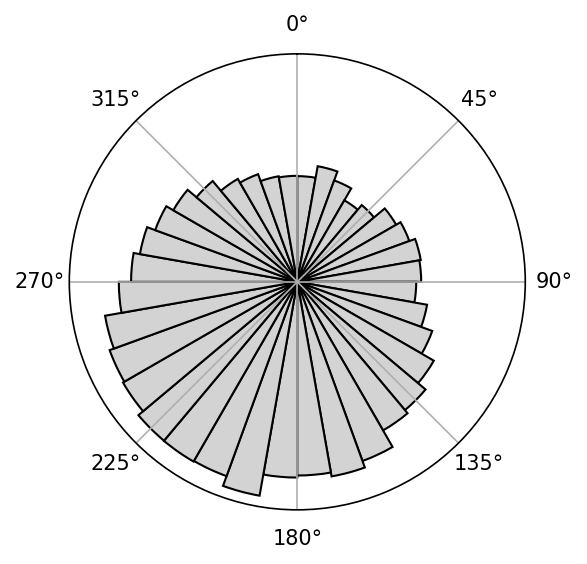

In [12]:

# ---------------------- Parameters ----------------------

cellindex = [24, 24]  # example cell index
r = pc_activity[:, cellindex[0], cellindex[1]]  # firing rate for this cell
spikes = np.random.poisson(r)

# Sink location grid
consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)
consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)

best_r = -np.inf
best_sink = None
best_direction = None


consink_loc = (0.*np.pi, 0.5*np.pi)

RelativeDirection, r_val = getSpike_RelativeDirection(
    consink_loc, Animal_location_all, Head_direction_all, spikes
)
if r_val > best_r:
    best_r = r_val
    best_sink = consink_loc
    best_direction = RelativeDirection


#ConSink plot
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1, projection='polar')  
#plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
ax.hist(RelativeDirection, bins=36, color='lightgrey', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
plt.tight_layout()


### calculate the best consink location for a cell

Best consink location: [0.41336745 0.57871444]
Max mean vector length (r): 0.206


(-0.5, 24.5, -0.5, 24.5)

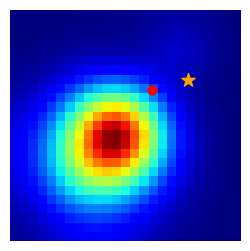

In [13]:
# ---------------------- Parameters ----------------------

cellindex = [24, 24]  # example cell index
r = pc_activity[:, cellindex[0], cellindex[1]]  # firing rate for this cell
spikes = np.random.poisson(r)

# Sink location grid
consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)
consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)

best_r = -np.inf
best_sink = None
best_direction = None

# ---------------------- Grid search ----------------------

for cx in consink_x:
    for cy in consink_y:
        consink_loc = np.array([cx, cy])
        # print(consink_loc)
        RelativeDirection, r_val = getSpike_RelativeDirection(
            consink_loc, Animal_location_all, Head_direction_all, spikes
        )
        if r_val > best_r:
            best_r = r_val
            best_sink = consink_loc
            best_direction = RelativeDirection

# ---------------------- Output&Plot ----------------------

print(f"Best consink location: {best_sink}")
print(f"Max mean vector length (r): {best_r:.3f}")

fig, ax = plt.subplots(1,1, figsize=(3,3))

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='jet', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

# mark the best sink location
sink_x = (best_sink[0] - Animal_location_all.min()) / (Animal_location_all.max() - Animal_location_all.min()) * dim
sink_y = (best_sink[1] - Animal_location_all.min()) / (Animal_location_all.max() - Animal_location_all.min()) * dim
ax.scatter(sink_x, sink_y, color='red', marker='o', s=40)

ax.axis('off')




### get the best sink for all cells

In [17]:
start_idx = 15
end_idx = 35  # inclusive
Best_sinks = []

AllR = []
AllBestR = []


for ii in range(start_idx, end_idx + 1, 3):
    for jj in range(start_idx, end_idx + 1, 3):
        
        print(ii, jj)
        r = pc_activity[:, ii, jj]  # firing rate for this cell
        spikes = np.random.poisson(r)

        # Sink location grid
        consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 15)
        consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 15)

        best_r = -np.inf
        best_sink = None
        best_direction = None

        # ---------------------- Grid search ----------------------
        sink_locs = []
        r4cell = []

        for cx in consink_x:
            for cy in consink_y:
                consink_loc = np.array([cx, cy])
                
                Animal_location_sub = Animal_location_all[Rotation_direction_all==0]
                Head_direction_sub = Head_direction_all[Rotation_direction_all==0]
                spikes_sub = spikes[Rotation_direction_all==0]
                
                RelativeDirection, r_val = getSpike_RelativeDirection(
                    consink_loc, Animal_location_sub, Head_direction_sub, spikes_sub
                )
                sink_locs.append(consink_loc)
                r4cell.append(r_val)

        # Convert to arrays
        r4cell = np.array(r4cell)
        sink_locs = np.array(sink_locs)

        # Sort and get top 10 indices
        top_idx = np.argsort(r4cell)[-10:]  # indices of top 10 r_val
        
        # Compute average consink location over top 10
        top_sinks = sink_locs[top_idx]
        avg_sink = np.mean(top_sinks, axis=0)
        
        AllBestR.append(np.mean(r4cell[top_idx]))

        # Store results
        AllR.append(r4cell)
        Best_sinks.append(avg_sink)


15 15
15 18
15 21
15 24
15 27
15 30
15 33
18 15
18 18
18 21
18 24
18 27
18 30
18 33
21 15
21 18
21 21
21 24
21 27
21 30
21 33
24 15
24 18
24 21
24 24
24 27
24 30
24 33
27 15
27 18
27 21
27 24
27 27
27 30
27 33
30 15
30 18
30 21
30 24
30 27
30 30
30 33
33 15
33 18
33 21
33 24
33 27
33 30
33 33


In [15]:
# for r in AllR:
#     plt.figure()
#     plt.hist(r)

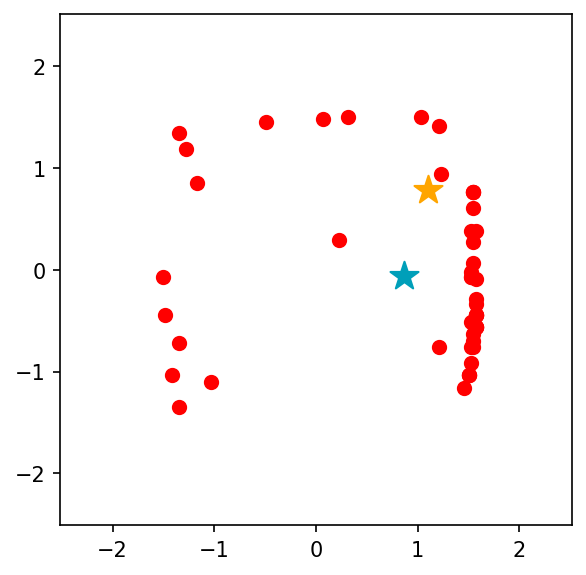

In [18]:


# Prepare figure
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# # Plot each best sink (normalized)
# for sink in Best_sinks:
#     ax.scatter(sink[0], sink[1], color='red', marker='o', s=40)

# Convert to arrays
Best_sinks_array = np.array(Best_sinks)
AllBestR_array = np.array(AllBestR)

# Determine threshold for top 20% r-values
threshold = np.percentile(AllBestR_array, 0)
top20_mask = AllBestR_array >= threshold

# Plot only top 20% sinks
top20_sinks = Best_sinks_array[top20_mask]
for sink in top20_sinks:
    ax.scatter(sink[0], sink[1], color='red', marker='o', s=40)

ax.scatter(goal_loc[0], goal_loc[1], color='orange', marker='*', s=200)

# Compute and plot mean best sink (blue star)
mean_sink = np.mean(np.vstack(Best_sinks), axis=0)
ax.scatter(mean_sink[0], mean_sink[1], color='#009FB9', marker='*', s=200)

ax.set_xlim(-0.8*np.pi, 0.8*np.pi)
ax.set_ylim(-0.8*np.pi, 0.8*np.pi)
ax.set_aspect('equal')
# ax.axis('off')
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/ConSinkMap_'+str(goal_loc[0]/np.pi)+'_'+str(goal_loc[1]/np.pi)+'.pdf')